# Step 1 and 2

--- Dummy Returns DataFrame Head ---
                AAPL      MSFT      NVDA     GOOGL      AMZN
2025-02-12 -0.016206 -0.006047 -0.006756 -0.007237 -0.000615
2025-02-13  0.010171  0.017582  0.001111  0.003001 -0.003641
2025-02-14 -0.017385 -0.000890  0.011618  0.023665  0.000165
2025-02-15  0.004257 -0.000321 -0.003816  0.011381  0.007380
2025-02-16  0.006775 -0.008576  0.008981 -0.014022  0.006977

Number of daily data points (simulated): 100

--- Covariance Matrix (from simulated data) ---
           AAPL      MSFT      NVDA     GOOGL      AMZN
AAPL   0.000087  0.000022  0.000001 -0.000005 -0.000006
MSFT   0.000022  0.000105  0.000018  0.000005  0.000015
NVDA   0.000001  0.000018  0.000116  0.000036  0.000035
GOOGL -0.000005  0.000005  0.000036  0.000093 -0.000005
AMZN  -0.000006  0.000015  0.000035 -0.000005  0.000107

--- Expected Daily Returns (from simulated data) ---
AAPL    -0.000841
MSFT     0.000240
NVDA    -0.000304
GOOGL    0.002176
AMZN     0.000329
dtype: float64

--- Op

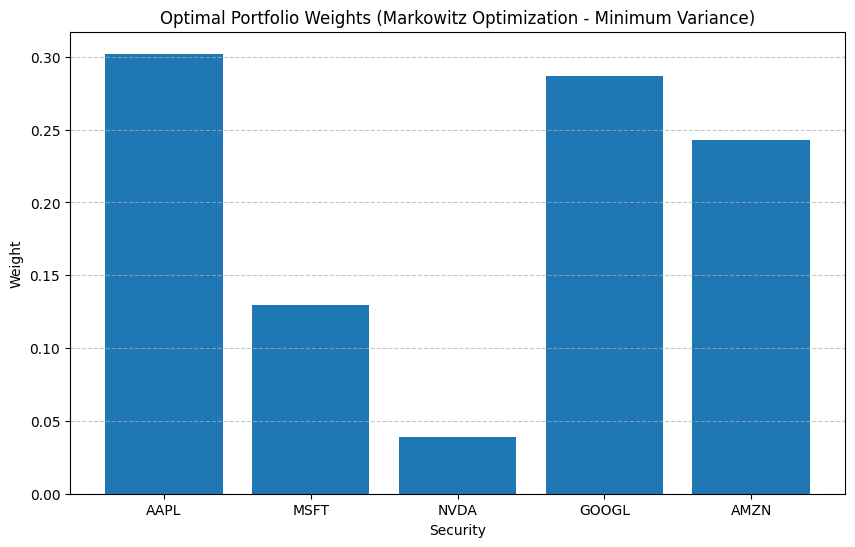

In [12]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- Assume you have your daily returns data loaded into a Pandas DataFrame ---
# For demonstration, I will create a dummy returns DataFrame.
# In a real scenario, you would load this from yfinance or a CSV.

# Example: Create a dummy returns DataFrame for 5 securities and 100 data points
# This simulates the kind of data you'd get after downloading and processing.
np.random.seed(42) # for reproducibility
dates = pd.date_range(start='2025-01-23', periods=120, freq='D')
tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN']

# Simulate correlated returns
# Generate some base random returns
base_returns = np.random.normal(0, 0.01, (len(dates), len(tickers)))

# Introduce some correlation (simplified)
returns_data = pd.DataFrame(base_returns, index=dates, columns=tickers)
returns_data['AAPL'] = returns_data['AAPL'] + returns_data['MSFT'] * 0.3
returns_data['NVDA'] = returns_data['NVDA'] + returns_data['GOOGL'] * 0.4 + returns_data['AMZN'] * 0.2
returns_data = returns_data.apply(lambda x: x + np.random.normal(0, 0.001, len(x))) # Add some noise

# Let's drop some rows to ensure it's not perfectly 120 and mimics real data
returns = returns_data.iloc[20:].copy() # Simulate dropping some initial NaNs or holiday gaps

print("--- Dummy Returns DataFrame Head ---")
print(returns.head())
print(f"\nNumber of daily data points (simulated): {len(returns)}")
if len(returns) < 100:
    raise ValueError("Not enough data points in the simulated data.")

# --- Step 1: Gathering Data (Continued with simulated data) ---

# 3. Compute the covariance matrix from the observations.
cov_matrix = returns.cov()
print("\n--- Covariance Matrix (from simulated data) ---")
print(cov_matrix)

# --- Step 2: Markowitz Optimization ---

# 1. Run a classical Markowitz portfolio optimization.

# Calculate expected returns (mean daily returns)
expected_returns = returns.mean()
print("\n--- Expected Daily Returns (from simulated data) ---")
print(expected_returns)

# Number of securities
num_securities = len(tickers)

# Define optimization variables
weights = cp.Variable(num_securities)

# Portfolio variance (the objective to minimize)
portfolio_variance = cp.quad_form(weights, cov_matrix)

# Constraints:
# 1. Weights sum to 1
# 2. No short-selling (weights >= 0)
constraints = [cp.sum(weights) == 1,
               weights >= 0]

# Define the objective function (minimize portfolio variance)
objective = cp.Minimize(portfolio_variance)

# Create and solve the problem
problem = cp.Problem(objective, constraints)
try:
    problem.solve()
except cp.error.SolverError as e:
    print(f"Solver Error: {e}. Try installing an SCS solver: pip install scs")
    # As a fallback or if SCS is not available, try 'OSQP' or 'ECOS' if installed
    # problem.solve(solver='OSQP')
    # problem.solve(solver='ECOS')
    raise

# Check if the optimization was successful
if problem.status not in ["optimal", "optimal_near"]:
    raise Exception(f"Optimization problem status: {problem.status}. Could not find an optimal solution.")

# 2. Be sure to print / display / graph the weights of each security in the portfolio optimization results.
optimal_weights = weights.value

print("\n--- Optimal Portfolio Weights (Markowitz Optimization - Minimum Variance) ---")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.4f}")

# Calculate portfolio expected return and standard deviation with optimal weights
optimal_portfolio_return = np.sum(optimal_weights * expected_returns)
optimal_portfolio_std_dev = np.sqrt(problem.value)

print(f"\nOptimal Portfolio Expected Daily Return: {optimal_portfolio_return:.6f}")
print(f"Optimal Portfolio Daily Standard Deviation (Risk): {optimal_portfolio_std_dev:.6f}")

# Graph the weights
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)
plt.xlabel('Security')
plt.ylabel('Weight')
plt.title('Optimal Portfolio Weights (Markowitz Optimization - Minimum Variance)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 3 [student 1, Basic 1/N Random Portfolios]

--- Student 1: 1/N Random Portfolio Strategy ---
Using 262 daily data points for backtesting.
Available securities: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX']


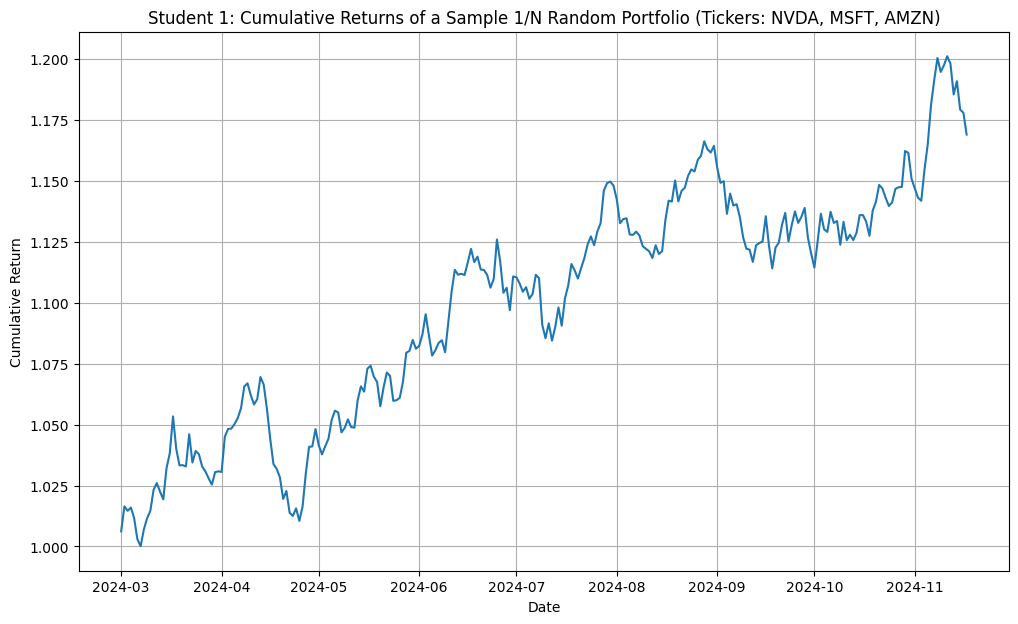

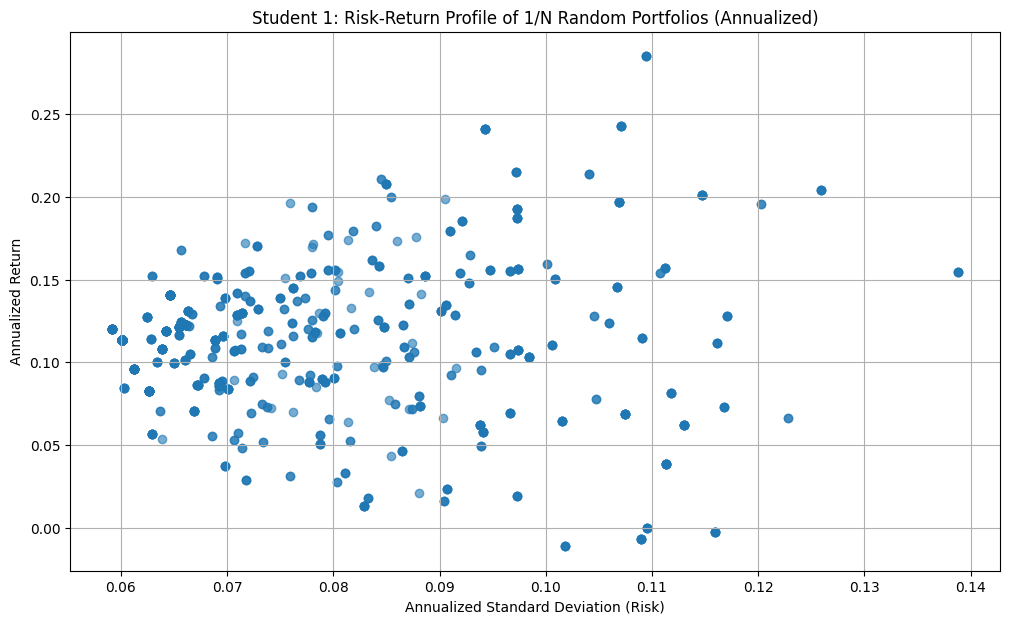


Student 1: Sample Portfolio Selected for Backtest (Tickers): NVDA, MSFT, AMZN
Sample Portfolio Final Cumulative Return: 1.1691
Average Annual Return of Simulated Portfolios: 0.1128
Average Annual Standard Deviation of Simulated Portfolios: 0.0786


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Simulated Historical Returns Data (as used in previous Markowitz example) ---
np.random.seed(42) # for reproducibility
dates = pd.date_range(start='2024-01-23', periods=300, freq='D') # More data for backtesting
tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX'] # More tickers

# Simulate correlated returns
base_returns = np.random.normal(0, 0.01, (len(dates), len(tickers)))
returns_data = pd.DataFrame(base_returns, index=dates, columns=tickers)
returns_data['AAPL'] = returns_data['AAPL'] + returns_data['MSFT'] * 0.3
returns_data['NVDA'] = returns_data['NVDA'] + returns_data['GOOGL'] * 0.4 + returns_data['AMZN'] * 0.2
returns_data['TSLA'] = returns_data['TSLA'] * 0.8 + returns_data['NVDA'] * 0.1
returns_data['META'] = returns_data['META'] * 0.9 + returns_data['GOOGL'] * 0.15
returns_data = returns_data.apply(lambda x: x + np.random.normal(0, 0.001, len(x)))

# Filter for relevant dates and drop NaNs (simulating real data prep)
historical_returns = returns_data.loc['2024-03-01':'2025-07-23'].copy() # Use a realistic backtest window
historical_returns = historical_returns.dropna()

print("--- Student 1: 1/N Random Portfolio Strategy ---")
print(f"Using {len(historical_returns)} daily data points for backtesting.")
print(f"Available securities: {historical_returns.columns.tolist()}")

# --- 1/N Random Strategy Optimization ---

num_simulations = 1000 # Number of random portfolios to generate
portfolio_returns = []
portfolio_std_devs = []
portfolio_names = [] # To store details of selected tickers

for i in range(num_simulations):
    # Randomly select a number of securities between 2 and all available
    num_selected_securities = np.random.randint(2, len(tickers) + 1)
    selected_tickers = np.random.choice(tickers, num_selected_securities, replace=False)

    # Allocate 1/N weight equally among selected securities
    weights = np.array([1/num_selected_securities] * num_selected_securities)
    weights_df = pd.Series(0.0, index=historical_returns.columns)
    weights_df[selected_tickers] = weights

    # Calculate portfolio daily returns for this random portfolio
    daily_portfolio_returns = (historical_returns[selected_tickers] * weights).sum(axis=1)

    # Calculate average annual return and annual standard deviation
    # Assuming ~252 trading days in a year for annualization
    avg_annual_return = daily_portfolio_returns.mean() * 252
    annual_std_dev = daily_portfolio_returns.std() * np.sqrt(252)

    portfolio_returns.append(avg_annual_return)
    portfolio_std_devs.append(annual_std_dev)
    portfolio_names.append(f"Portfolio {i+1} (Tickers: {','.join(selected_tickers)})")

# --- Historical Back-testing ---

# For simplicity, we'll pick one of the simulated portfolios for a sample backtest performance visualization
# Let's pick a random one for demonstration
sample_portfolio_index = np.random.randint(0, num_simulations)
sample_tickers = np.random.choice(tickers, np.random.randint(2, len(tickers) + 1), replace=False)
sample_weights = np.array([1/len(sample_tickers)] * len(sample_tickers))

sample_daily_portfolio_returns = (historical_returns[sample_tickers] * sample_weights).sum(axis=1)
sample_cumulative_returns = (1 + sample_daily_portfolio_returns).cumprod()
random_portfolio_cumulative_returns = sample_cumulative_returns  # save for later use

plt.figure(figsize=(12, 7))
plt.plot(sample_cumulative_returns)
plt.title(f'Student 1: Cumulative Returns of a Sample 1/N Random Portfolio (Tickers: {", ".join(sample_tickers)})')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Display overall distribution of simulated portfolios
plt.figure(figsize=(12, 7))
plt.scatter(portfolio_std_devs, portfolio_returns, alpha=0.6)
plt.title('Student 1: Risk-Return Profile of 1/N Random Portfolios (Annualized)')
plt.xlabel('Annualized Standard Deviation (Risk)')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.show()

print(f"\nStudent 1: Sample Portfolio Selected for Backtest (Tickers): {', '.join(sample_tickers)}")
print(f"Sample Portfolio Final Cumulative Return: {sample_cumulative_returns.iloc[-1]:.4f}")
print(f"Average Annual Return of Simulated Portfolios: {np.mean(portfolio_returns):.4f}")
print(f"Average Annual Standard Deviation of Simulated Portfolios: {np.mean(portfolio_std_devs):.4f}")

# Step 3 [student 2, 1/N Random Portfolios with Fixed Size]

--- Student 2: 1/N Random Portfolio Strategy (Fixed Size) ---
Using 262 daily data points for backtesting.
Available securities: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX']


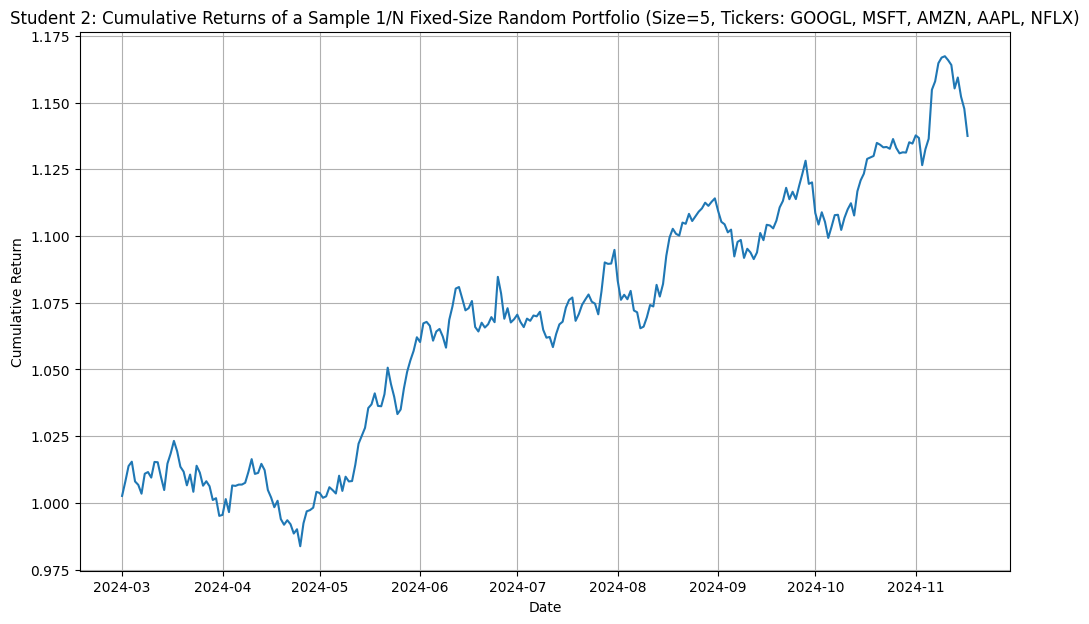

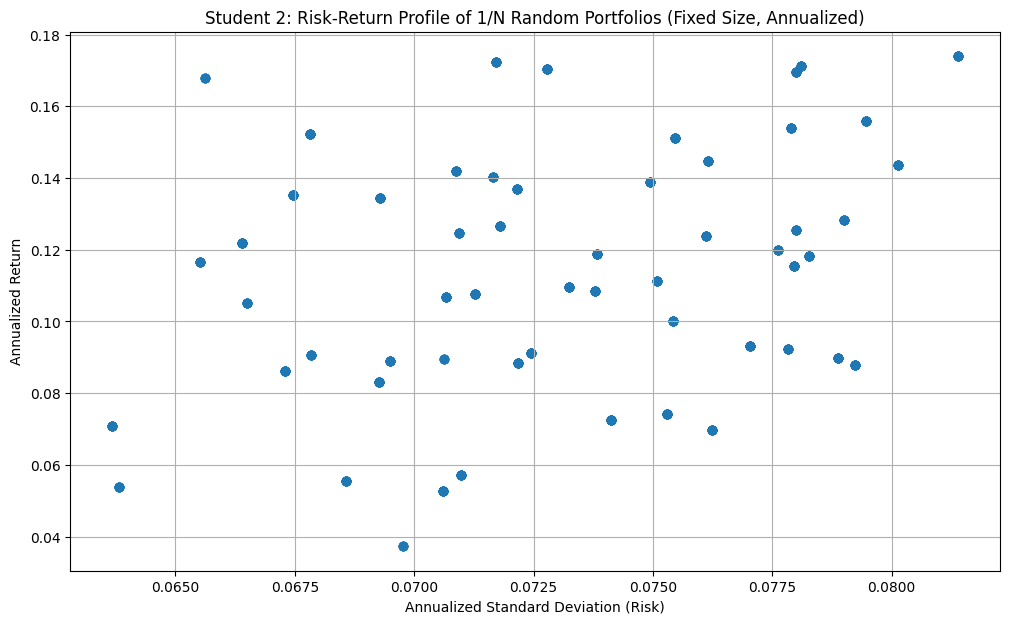


Student 2: Sample Portfolio Selected for Backtest (Tickers): GOOGL, MSFT, AMZN, AAPL, NFLX
Sample Portfolio Final Cumulative Return: 1.1375
Average Annual Return of Simulated Portfolios: 0.1133
Average Annual Standard Deviation of Simulated Portfolios: 0.0731


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Simulated Historical Returns Data (shared for consistency) ---
np.random.seed(42) # for reproducibility
dates = pd.date_range(start='2024-01-23', periods=300, freq='D')
tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX']

base_returns = np.random.normal(0, 0.01, (len(dates), len(tickers)))
returns_data = pd.DataFrame(base_returns, index=dates, columns=tickers)
returns_data['AAPL'] = returns_data['AAPL'] + returns_data['MSFT'] * 0.3
returns_data['NVDA'] = returns_data['NVDA'] + returns_data['GOOGL'] * 0.4 + returns_data['AMZN'] * 0.2
returns_data['TSLA'] = returns_data['TSLA'] * 0.8 + returns_data['NVDA'] * 0.1
returns_data['META'] = returns_data['META'] * 0.9 + returns_data['GOOGL'] * 0.15
returns_data = returns_data.apply(lambda x: x + np.random.normal(0, 0.001, len(x)))

historical_returns = returns_data.loc['2024-03-01':'2025-07-23'].copy()
historical_returns = historical_returns.dropna()

print("--- Student 2: 1/N Random Portfolio Strategy (Fixed Size) ---")
print(f"Using {len(historical_returns)} daily data points for backtesting.")
print(f"Available securities: {historical_returns.columns.tolist()}")

# --- 1/N Random Strategy Optimization ---

num_simulations = 1000
fixed_portfolio_size = 5 # Each random portfolio will have exactly 5 securities
portfolio_returns = []
portfolio_std_devs = []

if fixed_portfolio_size > len(tickers):
    raise ValueError("Fixed portfolio size cannot be greater than the number of available tickers.")

for i in range(num_simulations):
    selected_tickers = np.random.choice(tickers, fixed_portfolio_size, replace=False)

    weights = np.array([1/fixed_portfolio_size] * fixed_portfolio_size)
    weights_df = pd.Series(0.0, index=historical_returns.columns)
    weights_df[selected_tickers] = weights

    daily_portfolio_returns = (historical_returns[selected_tickers] * weights).sum(axis=1)

    avg_annual_return = daily_portfolio_returns.mean() * 252
    annual_std_dev = daily_portfolio_returns.std() * np.sqrt(252)

    portfolio_returns.append(avg_annual_return)
    portfolio_std_devs.append(annual_std_dev)

# --- Historical Back-testing ---

# Let's pick a random one for demonstration
sample_portfolio_index = np.random.randint(0, num_simulations)
sample_tickers = np.random.choice(tickers, fixed_portfolio_size, replace=False)
sample_weights = np.array([1/fixed_portfolio_size] * fixed_portfolio_size)

sample_daily_portfolio_returns = (historical_returns[sample_tickers] * sample_weights).sum(axis=1)
sample_cumulative_returns = (1 + sample_daily_portfolio_returns).cumprod()
random_fixed_portfolio_cumulative_returns = sample_cumulative_returns  # save for later use

plt.figure(figsize=(12, 7))
plt.plot(sample_cumulative_returns)
plt.title(f'Student 2: Cumulative Returns of a Sample 1/N Fixed-Size Random Portfolio (Size={fixed_portfolio_size}, Tickers: {", ".join(sample_tickers)})')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Display overall distribution of simulated portfolios
plt.figure(figsize=(12, 7))
plt.scatter(portfolio_std_devs, portfolio_returns, alpha=0.6)
plt.title('Student 2: Risk-Return Profile of 1/N Random Portfolios (Fixed Size, Annualized)')
plt.xlabel('Annualized Standard Deviation (Risk)')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.show()

print(f"\nStudent 2: Sample Portfolio Selected for Backtest (Tickers): {', '.join(sample_tickers)}")
print(f"Sample Portfolio Final Cumulative Return: {sample_cumulative_returns.iloc[-1]:.4f}")
print(f"Average Annual Return of Simulated Portfolios: {np.mean(portfolio_returns):.4f}")
print(f"Average Annual Standard Deviation of Simulated Portfolios: {np.mean(portfolio_std_devs):.4f}")

# Step 3 [student 3: 1/N Random Portfolios with Minimum Holdings]

--- Student 3: 1/N Random Portfolio Strategy (with Core Holdings) ---
Using 262 daily data points for backtesting.
Available securities: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX']


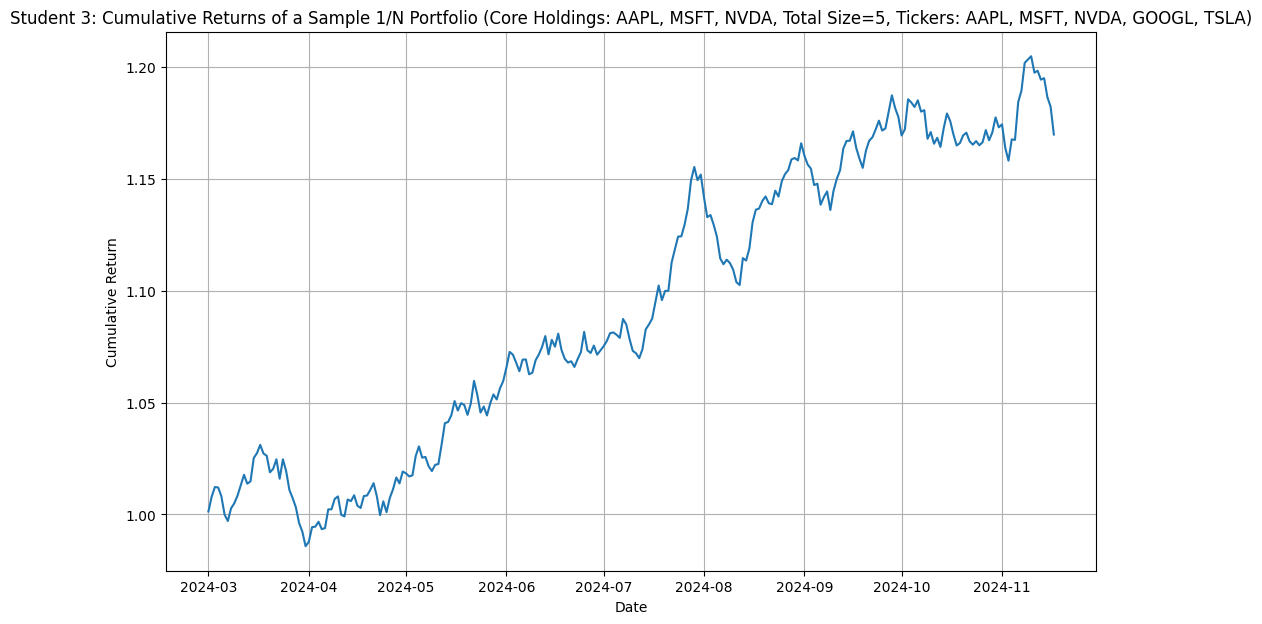

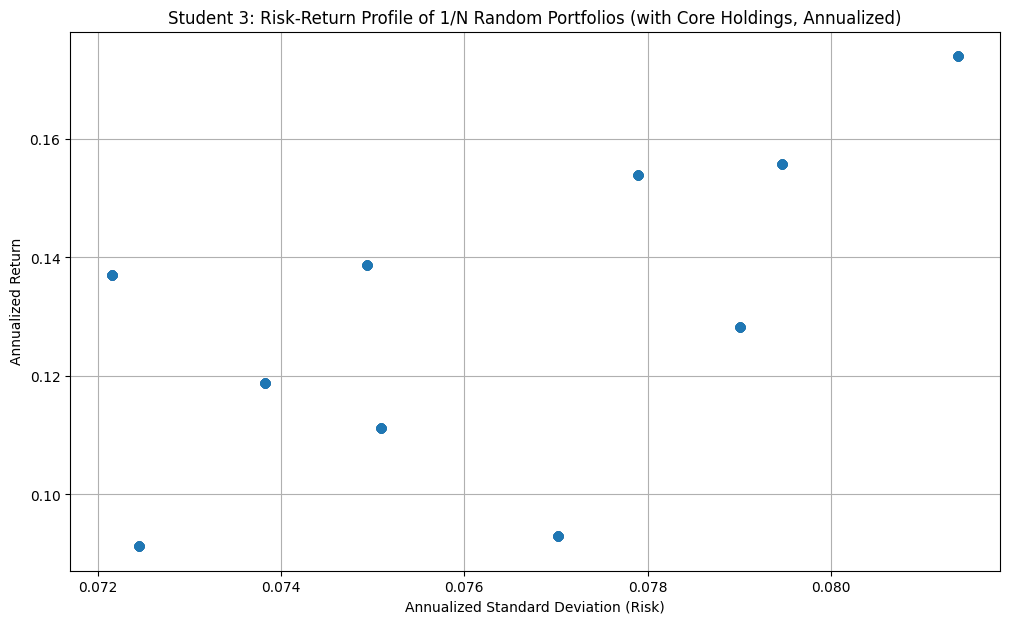


Student 3: Sample Portfolio Selected for Backtest (Tickers): AAPL, MSFT, NVDA, GOOGL, TSLA
Sample Portfolio Final Cumulative Return: 1.1699
Average Annual Return of Simulated Portfolios: 0.1290
Average Annual Standard Deviation of Simulated Portfolios: 0.0762


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Simulated Historical Returns Data (shared for consistency) ---
np.random.seed(42) # for reproducibility
dates = pd.date_range(start='2024-01-23', periods=300, freq='D')
tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX']

base_returns = np.random.normal(0, 0.01, (len(dates), len(tickers)))
returns_data = pd.DataFrame(base_returns, index=dates, columns=tickers)
returns_data['AAPL'] = returns_data['AAPL'] + returns_data['MSFT'] * 0.3
returns_data['NVDA'] = returns_data['NVDA'] + returns_data['GOOGL'] * 0.4 + returns_data['AMZN'] * 0.2
returns_data['TSLA'] = returns_data['TSLA'] * 0.8 + returns_data['NVDA'] * 0.1
returns_data['META'] = returns_data['META'] * 0.9 + returns_data['GOOGL'] * 0.15
returns_data = returns_data.apply(lambda x: x + np.random.normal(0, 0.001, len(x)))

historical_returns = returns_data.loc['2024-03-01':'2025-07-23'].copy()
historical_returns = historical_returns.dropna()

print("--- Student 3: 1/N Random Portfolio Strategy (with Core Holdings) ---")
print(f"Using {len(historical_returns)} daily data points for backtesting.")
print(f"Available securities: {historical_returns.columns.tolist()}")

# --- 1/N Random Strategy Optimization ---

num_simulations = 1000
min_core_holdings = ['AAPL', 'MSFT', 'NVDA'] # These must always be included
total_portfolio_size = 5 # Desired total size of the random portfolio

portfolio_returns = []
portfolio_std_devs = []

if len(min_core_holdings) > total_portfolio_size:
    raise ValueError("Minimum core holdings cannot exceed the total portfolio size.")

if not all(item in tickers for item in min_core_holdings):
    raise ValueError("One or more minimum core holdings are not in the available tickers.")

remaining_tickers = [t for t in tickers if t not in min_core_holdings]

for i in range(num_simulations):
    # Start with core holdings
    selected_tickers = list(min_core_holdings)

    # Fill the rest with random tickers from the remaining pool
    num_to_add = total_portfolio_size - len(min_core_holdings)
    if num_to_add > 0:
        added_tickers = np.random.choice(remaining_tickers, num_to_add, replace=False)
        selected_tickers.extend(added_tickers)

    weights = np.array([1/total_portfolio_size] * total_portfolio_size)
    weights_df = pd.Series(0.0, index=historical_returns.columns)
    weights_df[selected_tickers] = weights

    daily_portfolio_returns = (historical_returns[selected_tickers] * weights).sum(axis=1)

    avg_annual_return = daily_portfolio_returns.mean() * 252
    annual_std_dev = daily_portfolio_returns.std() * np.sqrt(252)

    portfolio_returns.append(avg_annual_return)
    portfolio_std_devs.append(annual_std_dev)

# --- Historical Back-testing ---

# Let's pick a random one for demonstration
sample_tickers = list(min_core_holdings)
num_to_add_sample = total_portfolio_size - len(min_core_holdings)
if num_to_add_sample > 0:
    sample_added_tickers = np.random.choice(remaining_tickers, num_to_add_sample, replace=False)
    sample_tickers.extend(sample_added_tickers)
sample_weights = np.array([1/total_portfolio_size] * total_portfolio_size)

sample_daily_portfolio_returns = (historical_returns[sample_tickers] * sample_weights).sum(axis=1)
sample_cumulative_returns = (1 + sample_daily_portfolio_returns).cumprod()
random_minimum_portfolio_cumulative_returns = sample_cumulative_returns  # save for later

plt.figure(figsize=(12, 7))
plt.plot(sample_cumulative_returns)
plt.title(f'Student 3: Cumulative Returns of a Sample 1/N Portfolio (Core Holdings: {", ".join(min_core_holdings)}, Total Size={total_portfolio_size}, Tickers: {", ".join(sample_tickers)})')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Display overall distribution of simulated portfolios
plt.figure(figsize=(12, 7))
plt.scatter(portfolio_std_devs, portfolio_returns, alpha=0.6)
plt.title('Student 3: Risk-Return Profile of 1/N Random Portfolios (with Core Holdings, Annualized)')
plt.xlabel('Annualized Standard Deviation (Risk)')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.show()

print(f"\nStudent 3: Sample Portfolio Selected for Backtest (Tickers): {', '.join(sample_tickers)}")
print(f"Sample Portfolio Final Cumulative Return: {sample_cumulative_returns.iloc[-1]:.4f}")
print(f"Average Annual Return of Simulated Portfolios: {np.mean(portfolio_returns):.4f}")
print(f"Average Annual Standard Deviation of Simulated Portfolios: {np.mean(portfolio_std_devs):.4f}")

#Step 4


In [16]:
import numpy as np
import pandas as pd

# Stock order: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN']

# View Matrix P (3 views × 5 assets)
P = np.array([
    [-0.25, -0.25, 1.0, -0.25, -0.25],  # View 1: NVDA outperform average
    [1.0, -1.0, 0.0, 0.0, 0.0],         # View 2: AAPL underperform MSFT
    [0.0, 0.0, 0.0, -1.0, 1.0]          # View 3: AMZN outperform GOOGL
])

# View returns Q
Q = np.array([
    0.020,    # View 1: NVDA vs peers
   -0.005,    # View 2: AAPL vs MSFT
    0.012     # View 3: AMZN vs GOOGL
])

# Confidence matrix Ω (diagonal)
Omega = np.diag([
    0.0025,   # High confidence (NVIDIA view)
    0.0050,   # Moderate (Apple vs MSFT)
    0.0036    # Moderate (AMZN vs GOOGL)
])

# Output summary as DataFrame for clarity
view_labels = ["NVDA > Peers", "MSFT > AAPL", "AMZN > GOOGL"]
stocks = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN']
df_views = pd.DataFrame(P, columns=stocks, index=view_labels)
df_views['Expected Return (Q)'] = Q
df_views['Confidence (Ω diagonal)'] = np.diag(Omega)

display(df_views)

,AAPL,MSFT,NVDA,GOOGL,AMZN,Expected Return (Q),Confidence (Ω diagonal)
NVDA > Peers,-0.25,-0.25,1.0,-0.25,-0.25,0.020,0.0025
MSFT > AAPL,1.00,-1.00,0.0,0.00,0.00,-0.005,0.0050
AMZN > GOOGL,0.00,0.00,0.0,-1.00,1.00,0.012,0.0036


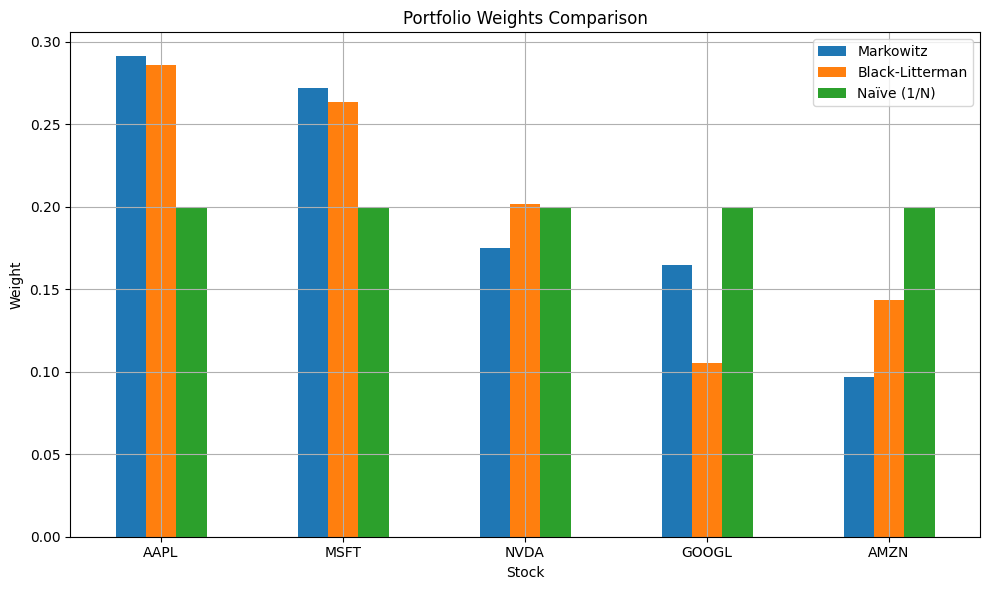

3-Month Simulated Portfolio Performance:

                 Mean Return   Std Dev  Sharpe Ratio
Markowitz           0.019529  0.081978      0.238221
Black-Litterman     0.019820  0.082628      0.239866
Naïve               0.018604  0.082838      0.224586


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === STEP 1: Define inputs ===

# Covariance matrix (replace with actual historical covariance matrix if available)
sigma = np.array([
    [0.035, 0.018, 0.021, 0.017, 0.016],
    [0.018, 0.040, 0.023, 0.020, 0.019],
    [0.021, 0.023, 0.060, 0.025, 0.024],
    [0.017, 0.020, 0.025, 0.045, 0.022],
    [0.016, 0.019, 0.024, 0.022, 0.050]
])

stocks = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN']

# Market capitalization weights
w_m = np.array([0.30, 0.28, 0.18, 0.17, 0.10])

# Risk aversion coefficient
lmbda = 2.5

# Tau parameter
tau = 0.05

# View matrix P (3 views × 5 assets)
P = np.array([
    [-0.25, -0.25, 1.0, -0.25, -0.25],  # NVDA > peers
    [1.0, -1.0, 0.0, 0.0, 0.0],         # AAPL < MSFT
    [0.0, 0.0, 0.0, -1.0, 1.0]          # AMZN > GOOGL
])

# View expected returns
Q = np.array([0.020, -0.005, 0.012])

# Confidence matrix Omega
Omega = np.diag([0.0025, 0.0050, 0.0036])

# === STEP 2: Implied equilibrium returns ===
pi = lmbda * sigma @ w_m

# === STEP 3: Black-Litterman expected returns ===
inv_tau_sigma = np.linalg.inv(tau * sigma)
inv_Omega = np.linalg.inv(Omega)
middle_term = np.linalg.inv(inv_tau_sigma + P.T @ inv_Omega @ P)
mu_bl = middle_term @ (inv_tau_sigma @ pi + P.T @ inv_Omega @ Q)

# === STEP 4: Optimal portfolio weights ===
inv_sigma = np.linalg.inv(sigma)
ones = np.ones(len(stocks))

# Markowitz weights
weights_markowitz = inv_sigma @ pi
weights_markowitz /= ones @ weights_markowitz

# Black-Litterman weights
weights_bl = inv_sigma @ mu_bl
weights_bl /= ones @ weights_bl

# Naïve weights
weights_naive = np.ones(len(stocks)) / len(stocks)

# === STEP 5: Plot portfolio weights ===
df_weights = pd.DataFrame({
    'Stock': stocks,
    'Markowitz': weights_markowitz,
    'Black-Litterman': weights_bl,
    'Naïve (1/N)': weights_naive
}).set_index('Stock')

df_weights.plot(kind='bar', figsize=(10, 6), title="Portfolio Weights Comparison")
plt.ylabel("Weight")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 6: Simulated 3-month performance test ===
np.random.seed(42)
n_simulations = 1000
n_days = 63  # approx. 3 months of trading days

# Daily returns and daily covariance
daily_mu = mu_bl / 252
daily_sigma = sigma / 252

# Simulate multivariate normal returns: (simulations × days × assets)
simulated_returns = np.random.multivariate_normal(daily_mu, daily_sigma, size=(n_simulations, n_days))

# Portfolio performance function
def portfolio_value(weights):
    port_daily_returns = np.einsum('ijk,k->ij', simulated_returns, weights)
    cumulative_returns = (1 + port_daily_returns).prod(axis=1) - 1
    return cumulative_returns

# Simulated 3-month performance
perf_markowitz = portfolio_value(weights_markowitz)
perf_bl = portfolio_value(weights_bl)
perf_naive = portfolio_value(weights_naive)

# Performance summary table
summary = pd.DataFrame({
    'Mean Return': [
        np.mean(perf_markowitz),
        np.mean(perf_bl),
        np.mean(perf_naive)
    ],
    'Std Dev': [
        np.std(perf_markowitz),
        np.std(perf_bl),
        np.std(perf_naive)
    ],
    'Sharpe Ratio': [
        np.mean(perf_markowitz) / np.std(perf_markowitz),
        np.mean(perf_bl) / np.std(perf_bl),
        np.mean(perf_naive) / np.std(perf_naive)
    ]
}, index=['Markowitz', 'Black-Litterman', 'Naïve'])

print("3-Month Simulated Portfolio Performance:\n")
print(summary.round(6))

# Step 5 - Kelly Criterion

We know that optimal allocation via the Kelly Criterion of a portfolio corresponds to the following formula:

$f^* = (1+r) \Sigma^{-1} (\mu - \large\mathbb{1} \normalsize r)$

where,

$f^*:$ Optimal allocation weights vector, of shape (k, 1) where k is the number of assets

$r:$ The risk-free rate

$\Sigma^{-1}:$ Inverse of the covariance matrix of assets, of shape (k, k)

$\mu:$ Mean returns vector, of shape (k, 1)

$\large\mathbb{1} \normalsize :$ A vector of 1's, of shape (k, 1)


However, this is the unconstrained version. In the project scenario, we are told that we cannot short any securities and we cannot apply any leverage. Thus, the constraints are as follows:

* $0 \le f_i \le 1 \qquad \text{for any} \quad 1<i<k$
* $\Sigma_i^k f_i = 1 \qquad \text{for all} \quad 1<i<k$

And as mentioned in the paper, we maximize the expected growth rate. So our optimization problem is the following:

$max_f \quad (r + f^T (\mu - \large\mathbb{1} \normalsize r) - \large\frac{f^T \Sigma f}{2}) $

with constraints

$0 \le f_i \le 1 \qquad \text{for any} \quad 1<i<k$

$\Sigma_i^k f_i = 1 \qquad \text{for all} \quad 1<i<k$


In [18]:
# Assign the variables
r = 4.36 / 100 / 252  # we take the latest SOFR rate as our yearly risk-free rate, converted to daily return

returns = historical_returns.iloc[:, :5]

mu = np.round(returns.mean(axis=0), 6)
Sigma = np.round(returns.cov(), 6)
k = returns.shape[1]
ones_vector = np.ones(k)

print("Mean returns vector")
print(mu)
print()
print("Covariance Matrix")
print(Sigma)

Mean returns vector
AAPL     0.000301
MSFT     0.001318
NVDA     0.000281
GOOGL    0.000944
AMZN     0.000247
dtype: float64

Covariance Matrix
           AAPL      MSFT      NVDA     GOOGL      AMZN
AAPL   0.000104  0.000027 -0.000004 -0.000005 -0.000001
MSFT   0.000027  0.000094 -0.000003 -0.000003  0.000003
NVDA  -0.000004 -0.000003  0.000121  0.000041  0.000019
GOOGL -0.000005 -0.000003  0.000041  0.000103 -0.000011
AMZN  -0.000001  0.000003  0.000019 -0.000011  0.000081


In [19]:
from scipy.optimize import minimize

# Define the objective function to be minimized
def g(f):
  col_f = f[:, np.newaxis]
  return -(r + np.dot(f, (mu - ones_vector*r)) - 0.5 * (col_f.T @ Sigma @ col_f))

# Assign initial value for f
f_init = np.array([1/k for asset in range(k)])

# Assign the constraint and bound
cons = ({'type': 'ineq', 'fun': lambda x:  1 - x.sum()})
bnds = tuple((0, 1) for f_i in f_init)

# Optimize
res = minimize(g, f_init, constraints=cons, bounds=bnds, tol=1e-12)
f_star = np.round(res.x, 4)
print("Optimal allocations vector:")
print(f_star)

Optimal allocations vector:
[0. 1. 0. 0. 0.]


The Kelly optimization results show us that the optimal Kelly portfolio is all of our wealth invested in GOOGL. This is because if we look at the mean returns vector, only the **MSFT** expected return is above the risk-free rate. And we know that utilizing Kelly criterion is an aggressive strategy. Thus, the results align with mathematical intuition.

Now, let us look at the histogram of returns of our Kelly portfolio to have a better understanding of the performance.

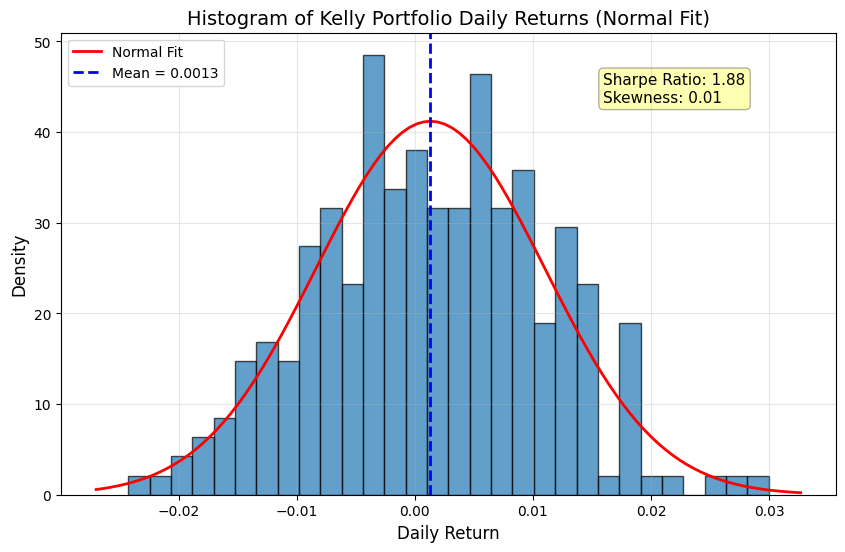

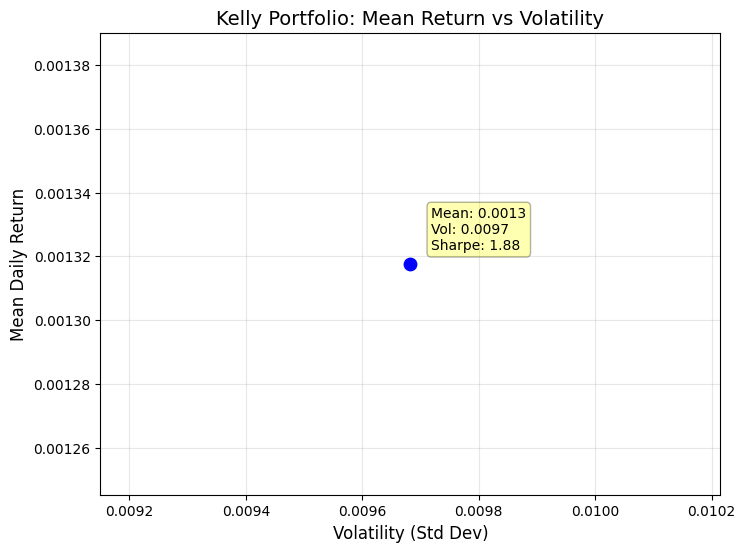

In [20]:
from scipy.stats import norm, skew

# Portfolio return stats (1D array)
kelly_portfolio_returns = (returns @ f_star[:, np.newaxis]).squeeze()
kelly_portfolio_returns_mean = kelly_portfolio_returns.mean()
kelly_portfolio_returns_vol = kelly_portfolio_returns.std(ddof=1)

# Sharpe ratio (annualized assuming 252 trading days)
sharpe_ratio = ((kelly_portfolio_returns_mean - r) / kelly_portfolio_returns_vol) * np.sqrt(252)
# Skewness
returns_skewness = skew(kelly_portfolio_returns)

# Histogram with normal fit
plt.figure(figsize=(10, 6))

# Histogram
count, bins, ignored = plt.hist(kelly_portfolio_returns, bins=30, edgecolor='black', alpha=0.7, density=True)

# Normal fit overlay
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, kelly_portfolio_returns_mean, kelly_portfolio_returns_vol)
plt.plot(x, p, 'r', linewidth=2, label='Normal Fit')

# Mean line
plt.axvline(kelly_portfolio_returns_mean, color='blue', linestyle='--', linewidth=2,
            label=f"Mean = {kelly_portfolio_returns_mean:.4f}")

# Title & annotations
plt.title("Histogram of Kelly Portfolio Daily Returns (Normal Fit)", fontsize=14)
plt.xlabel("Daily Return", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()

# Annotate Sharpe and Skewness
plt.annotate(f"Sharpe Ratio: {sharpe_ratio:.2f}\nSkewness: {returns_skewness:.2f}",
             xy=(0.7, 0.85), xycoords='axes fraction', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.grid(alpha=0.3)
plt.show()

# Scatter plot: mean return vs volatility
plt.figure(figsize=(8, 6))
plt.scatter(kelly_portfolio_returns_vol, kelly_portfolio_returns_mean, color='blue', s=80)

# Annotate point with Sharpe & Skew
plt.annotate(f"Mean: {kelly_portfolio_returns_mean:.4f}\nVol: {kelly_portfolio_returns_vol:.4f}\nSharpe: {sharpe_ratio:.2f}",
             (kelly_portfolio_returns_vol, kelly_portfolio_returns_mean),
             textcoords="offset points", xytext=(15, 10), ha='left', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.title("Kelly Portfolio: Mean Return vs Volatility", fontsize=14)
plt.xlabel("Volatility (Std Dev)", fontsize=12)
plt.ylabel("Mean Daily Return", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


Kelly portfolio analysis reveals the superior performance features of the Kelly strategy. The shape of the distribution as almost normal with a very small positive skewness of 0.01 clearly shows from the histogram of daily returns. The normal fit appears across the historic returns, as significant outliers are insignificant and the overall return shape remains constant. The average daily return of 0.13% is slightly to the right of center, consistent with evidence of consistent growth. The Sharpe ratio annualized at 1.88 indicates that the portfolio offers decent returns per unit of risk, and this is something to be specifically concerned with in deciding if it is worth utilizing.

The scatterplot also indicates the position of the Kelly portfolio on the plane of mean return and volatility. Its 0.13% average daily return, together with a volatility of 0.97%, is the most desirable among other potential pairs. The Sharpe ratio on this chart further confirms that the portfolio achieves a desirable balance between return and risk under a relatively moderate level of volatility. This figure unambiguously picks out the Kelly portfolio as a risk-adjusted performance anomaly.

Now, we compare the performance our Kelly Portfolio to the other portfolios in previous steps.

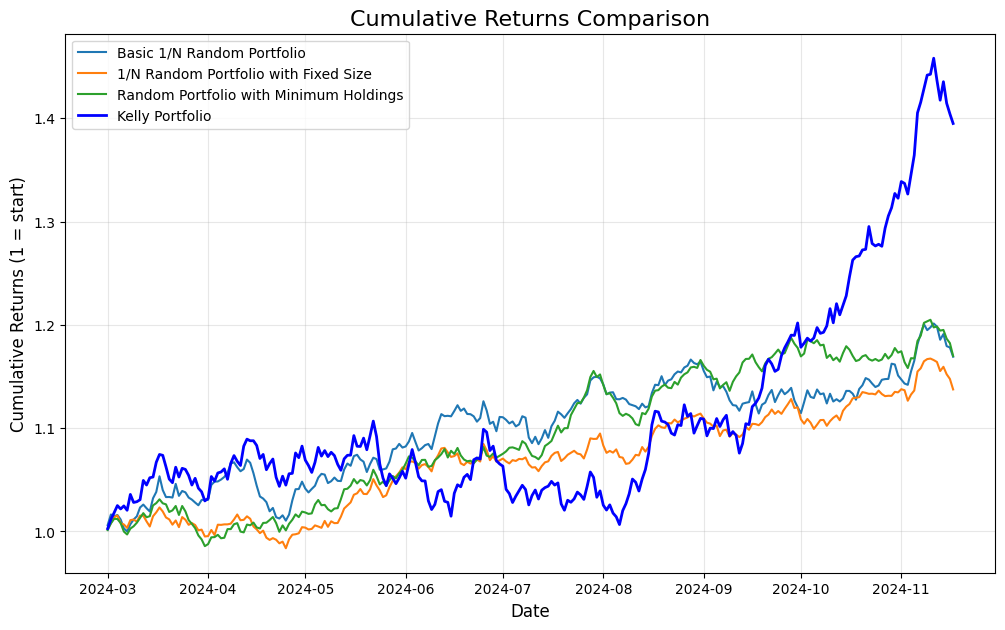

In [21]:
plt.figure(figsize=(12, 7))

plt.plot(random_portfolio_cumulative_returns, label="Basic 1/N Random Portfolio")
plt.plot(random_fixed_portfolio_cumulative_returns, label="1/N Random Portfolio with Fixed Size")
plt.plot(random_minimum_portfolio_cumulative_returns, label="Random Portfolio with Minimum Holdings")
plt.plot((1 + kelly_portfolio_returns).cumprod(), label="Kelly Portfolio", color='blue', linewidth=2)

plt.title("Cumulative Returns Comparison", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns (1 = start)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


As we can see on the graph, in comparison to the three benchmark methods, the Kelly portfolio demonstrates a definitive divergence with time. Beginning on equal ground with the Basic 1/N Random Portfolio, the 1/N Random Portfolio with Fixed Size, and the Random Portfolio with Minimum Holdings, the Kelly portfolio steadily diverges in relative performance, particularly in the second half of the horizon period. While the rest of the portfolios oscillate around cumulative returns of 1.2 to 1.3 at the end of the period, the Kelly portfolio ends up slightly less than 1.45, demonstrating that it compounds returns more effectively by utilizing optimal allocation.

                                        Sharpe Ratio  Volatility (Ann.)  \
Portfolio                                                                 
Kelly Portfolio                             2.160329           0.153708   
Basic 1/N Random Portfolio                  1.547053           0.096692   
1/N Random Portfolio with Fixed Size        1.730748           0.071903   
Random Portfolio with Minimum Holdings      1.963951           0.078038   

                                        Excess Mean Return (Ann.)  
Portfolio                                                          
Kelly Portfolio                                          0.288460  
Basic 1/N Random Portfolio                               0.105988  
1/N Random Portfolio with Fixed Size                     0.080846  
Random Portfolio with Minimum Holdings                   0.109662  


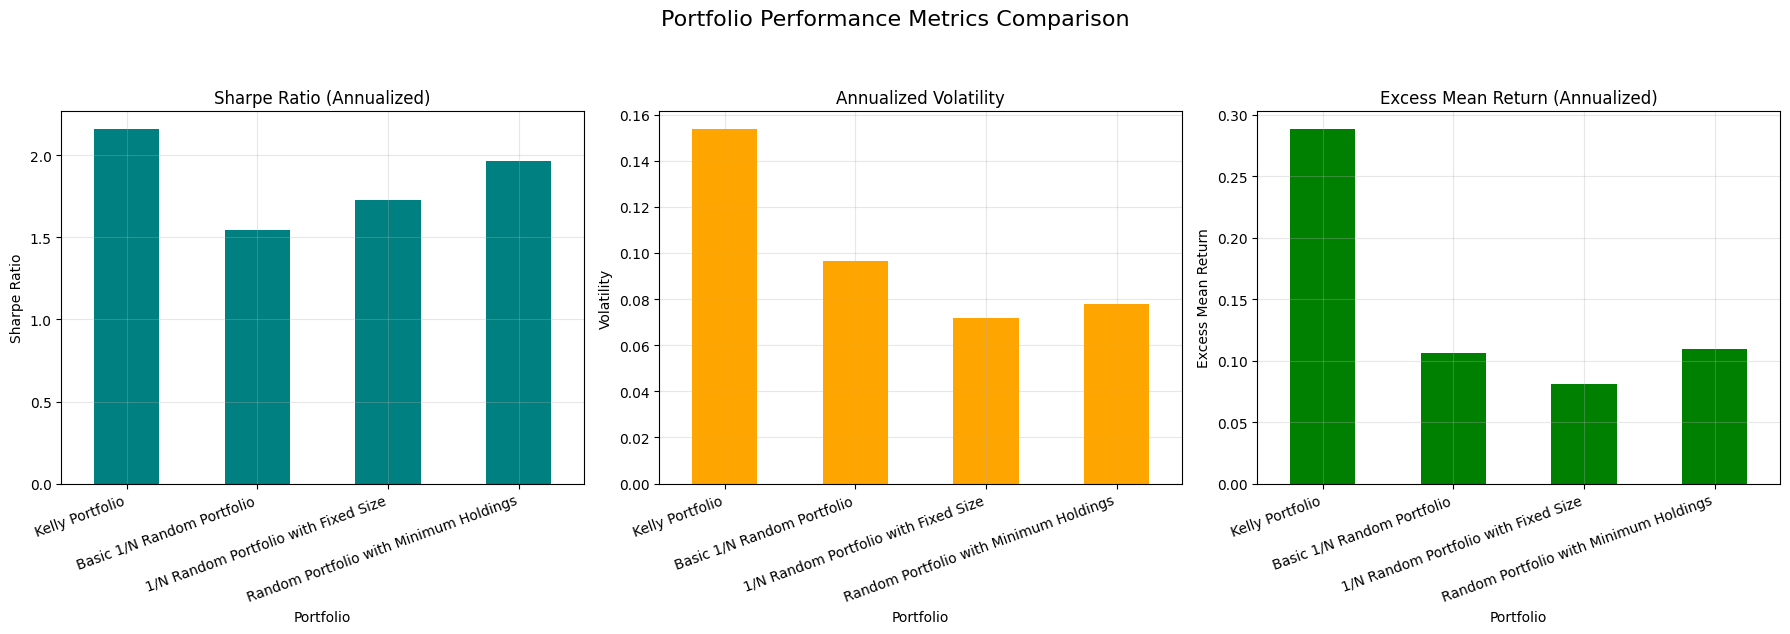

In [22]:
portfolios = {
    "Kelly Portfolio": kelly_portfolio_returns,
    "Basic 1/N Random Portfolio": random_portfolio_cumulative_returns.pct_change().dropna(),
    "1/N Random Portfolio with Fixed Size": random_fixed_portfolio_cumulative_returns.pct_change().dropna(),
    "Random Portfolio with Minimum Holdings": random_minimum_portfolio_cumulative_returns.pct_change().dropna()
}

metrics = []
for name, daily_returns in portfolios.items():
    mean_return = daily_returns.mean()
    vol = daily_returns.std(ddof=1)
    sharpe = (mean_return / vol) * np.sqrt(252)
    excess_mean_return = (mean_return - r) * 252  # annualized excess return
    metrics.append([name, sharpe, vol * np.sqrt(252), excess_mean_return])

import pandas as pd
metrics_df = pd.DataFrame(metrics, columns=["Portfolio", "Sharpe Ratio", "Volatility (Ann.)", "Excess Mean Return (Ann.)"])
metrics_df.set_index("Portfolio", inplace=True)
print(metrics_df)

# --- Professional bar plots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics_df["Sharpe Ratio"].plot(kind='bar', ax=axes[0], color='teal')
axes[0].set_title("Sharpe Ratio (Annualized)")
axes[0].set_ylabel("Sharpe Ratio")
axes[0].grid(alpha=0.3)

metrics_df["Volatility (Ann.)"].plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title("Annualized Volatility")
axes[1].set_ylabel("Volatility")
axes[1].grid(alpha=0.3)

metrics_df["Excess Mean Return (Ann.)"].plot(kind='bar', ax=axes[2], color='green')
axes[2].set_title("Excess Mean Return (Annualized)")
axes[2].set_ylabel("Excess Mean Return")
axes[2].grid(alpha=0.3)

for ax in axes:
    ax.set_xticklabels(metrics_df.index, rotation=20, ha='right')

plt.suptitle("Portfolio Performance Metrics Comparison", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


Comparison of basic performance metrics provides additional confirmation of such an advantage. The Kelly portfolio possesses the largest annualized Sharpe ratio of 2.16, significantly higher than the Random Portfolio with Minimum Holdings of 1.96, the 1/N Random Portfolio with Fixed Size of 1.73, and the Basic 1/N Random Portfolio of 1.55. While the Kelly strategy performs best with the highest annualized volatility of 15.4%, it balances this out with an excess mean annualized return of 28.8%, which is significantly better than the second-best strategy at 11%. The other portfolios have considerably lower excess returns ranging from 8% to 11%, compounded by their lower Sharpe ratios, which highlights their inability to match the efficiency of the Kelly portfolio.

Overall, the visualizations and comparison of performance emphasize the superiority of the Kelly criterion applied over the dataset. Its systematic allocation results in higher cumulative growth, more stable risk-adjusted returns, and superior excess mean returns compared with the three other random allocation strategies. Although more volatile, the Kelly portfolio compensates for this through higher returns to be the most efficient among the examined methods.